Estimated Beta: [-0.58773695  1.04127366]
True Beta: [-0.8, 1.5]
Optimal Prices: [20.00000017 23.74557599 23.74554664]


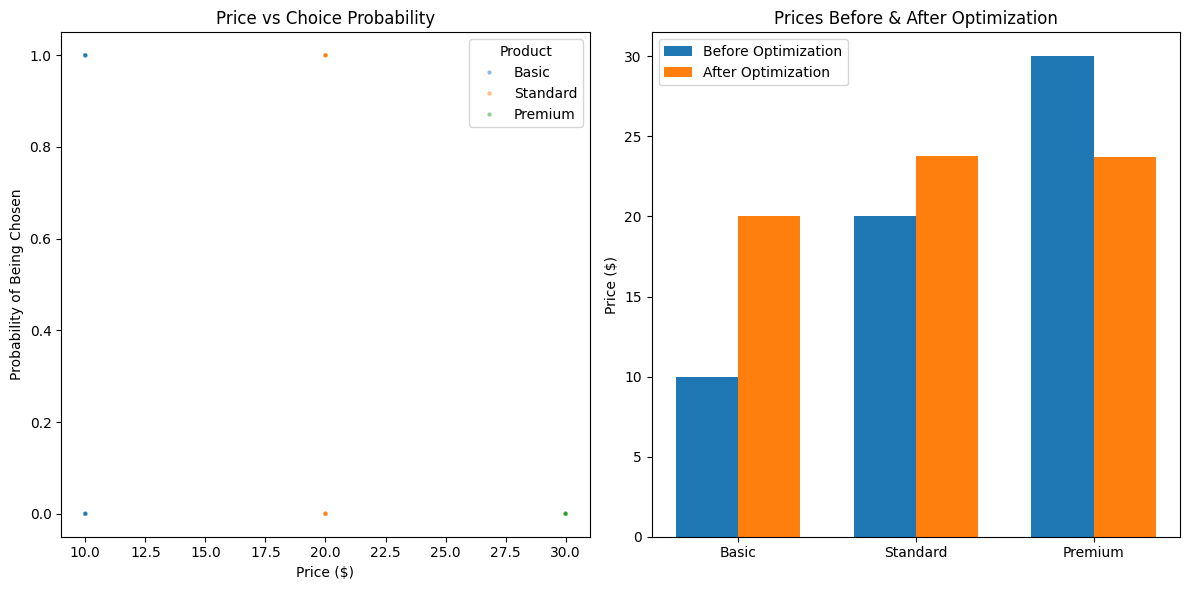

In [22]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns

# Simulating a dataset for pricing optimization
# np.random.seed(42)
N = 1000  # Number of customers
J = 3     # Number of product options

# Alternative-specific attributes (Price, Quality) - same across individuals
base_prices = np.array([10, 20, 30])  # Price for Basic, Standard, Premium
quality = np.array([1, 2, 3])  # Quality level for Basic, Standard, Premium

# True preference weights (Beta values)
beta_price = -0.8  # Sensitivity to price (negative: higher price lowers utility)
beta_quality = 1.5  # Sensitivity to quality (positive: higher quality increases utility)

# Compute utilities (excluding noise)
U = beta_price * base_prices + beta_quality * quality  # Shape (J,)
U = np.tile(U, (N, 1))  # Repeat for all individuals (N, J)

# Add a Gumbel noise term to simulate realistic choice randomness
gumbel_noise = np.random.gumbel(loc=0, scale=1, size=(N, J))  # Gumbel noise per alternative
U += gumbel_noise  # Add noise

# Simulate choices using softmax probabilities
def softmax(U):
    exp_U = np.exp(U - np.max(U, axis=1, keepdims=True))  # Prevent overflow
    return exp_U / exp_U.sum(axis=1, keepdims=True)

P = softmax(U)  # Choice probabilities
# Make stochastic choices
choices = np.array([np.random.choice(J, p=P[i]) for i in range(N)])

# Organizing data into a DataFrame
df = pd.DataFrame({
    "Customer": np.repeat(np.arange(N), J),
    "Product": np.tile(["Basic", "Standard", "Premium"], N),
    "Chosen": (np.tile(np.arange(J), N) == np.repeat(choices, J)).astype(int),
    "Price": np.tile(base_prices, N),
    "Quality": np.tile(quality, N)
})

# Log-likelihood function for estimation
def log_likelihood(beta, X, choices):
    U = np.einsum('ijk,k->ij', X, beta)  # Compute utilities
    P = softmax(U)  # Compute probabilities
    chosen_probs = P[np.arange(N), choices]  # Get probability of chosen option
    return -np.sum(np.log(chosen_probs))  # Negative log-likelihood

# Prepare data for estimation
X_columns = ["Price", "Quality"]
X = df[X_columns].values.reshape(N, J, -1)  # Reshape for estimation
choices = df["Chosen"].values.reshape(N, J).argmax(axis=1)  # Convert to choice indices

# Initialize beta with reasonable priors
initial_beta = np.array([-1.0, 1.0])  # Start with negative price sensitivity and positive quality sensitivity

# Estimating parameters using MLE
result = opt.minimize(log_likelihood, initial_beta, args=(X, choices), method='BFGS')

# Use estimated beta for optimization
estimated_beta_price, estimated_beta_quality = result.x
print("Estimated Beta:", result.x)
print("True Beta:", [beta_price, beta_quality])

# Optimal Pricing Strategy: Adjust prices to maximize revenue
def revenue_function(prices):
    U_opt = estimated_beta_price * prices + estimated_beta_quality * quality  # Systematic utility
    U_opt -= np.max(U_opt)  # Normalize to prevent overflow
    exp_U = np.exp(U_opt)
    P_opt = exp_U / np.sum(exp_U)  # Compute choice probabilities
    expected_sales = P_opt * N  # Expected number of sales per option
    revenue = np.sum(expected_sales * prices)  # Total revenue
    
    # Apply a penalty if prices are too high
    penalty = np.sum(np.maximum(prices - 50, 0))  # Penalize prices over $50
    return -revenue + penalty  # Minimize negative revenue + penalty to control excessive pricing

# Demand elasticity constraint: Ensures that if price rises, demand doesn’t collapse
def elasticity_constraint(prices):
    price_change = np.abs(prices - base_prices)
    return 10 - np.max(price_change)  # Ensure max price change is within reasonable elasticity bounds

# Constrain prices to be between $5 and $50
bounds = [(5, 50)] * J
constraints = [{'type': 'ineq', 'fun': elasticity_constraint}]

# Optimize price strategy with constraints
optimized_result = opt.minimize(revenue_function, base_prices, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_prices = optimized_result.x

df['OptimalPrice'] = np.tile(optimal_prices, N)
print("Optimal Prices:", optimal_prices)

# Visualization
plt.figure(figsize=(12, 6))

# Scatter plot of Price vs. Market Share
plt.subplot(1, 2, 1)
sns.scatterplot(x=df["Price"], y=df["Chosen"], hue=df["Product"], s=10, alpha=0.5)
plt.xlabel("Price ($)")
plt.ylabel("Probability of Being Chosen")
plt.title("Price vs Choice Probability")
plt.legend(title="Product")

# Bar plot of original vs optimal prices
plt.subplot(1, 2, 2)
x_labels = ["Basic", "Standard", "Premium"]
x = np.arange(len(x_labels))
width = 0.35
plt.bar(x - width/2, base_prices, width, label='Before Optimization')
plt.bar(x + width/2, optimal_prices, width, label='After Optimization')
plt.xticks(ticks=x, labels=x_labels)
plt.ylabel("Price ($)")
plt.title("Prices Before & After Optimization")
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
df

,Customer,Product,Chosen,Price,Quality,OptimalPrice
0,0,Basic,1,10,1,2.525846e+51
1,0,Standard,0,20,2,3.457643e+51
2,0,Premium,0,30,3,1.057203e+51
3,1,Basic,1,10,1,2.525846e+51
4,1,Standard,0,20,2,3.457643e+51
...,...,...,...,...,...,...
2995,998,Standard,0,20,2,3.457643e+51
2996,998,Premium,0,30,3,1.057203e+51
2997,999,Basic,1,10,1,2.525846e+51
2998,999,Standard,0,20,2,3.457643e+51
